# R Text Analytics - Topic Modelling and Sentiment  on Amazon Comments

## Retrieve comments from a product on Amazon and perform Text Analytics such as Topic Modelling and Sentiment.

In [ ]:
#Load Packages
#suppressPackageStartupMessages()
options(warn=-1) #surpress warnings for presentation purposes only
library(xml2)
library(rvest)
library(stringr)
suppressWarnings(library(dplyr))
library(wordcloud)
library(tm)
library(textstem)
library(ggplot2)
library(SnowballC)
library(lubridate)
library(topicmodels)
library(cluster)
library(proxy)
library(slam)
#install.packages('fpc', repos=c("http://rstudio.org/_packages", "http://cran.rstudio.com"), dependencies = TRUE)
#install.packages('lattice', repos=c("http://rstudio.org/_packages", "http://cran.rstudio.com"), dependencies = TRUE)
suppressWarnings(library(fpc))
suppressWarnings(library(nnet))
suppressWarnings(library(MASS))
suppressWarnings(library(lattice))

th = theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

## Scrape the Data from Amazon's Website

In [2]:
#Create a function that retries comment data from Amazon
#Source: This function is based on the following blog...https://justrthings.com/2019/03/03/web-scraping-amazon-reviews-march-2019/

scrape_amazon <- function(url, throttle = 0){
  
  webpage <- read_html(url)

  # Set throttle between URL calls
  sec = 0
  if(throttle < 0) warning("throttle was less than 0: set to 0")
  if(throttle > 0) sec = max(0, throttle + runif(1, -1, 1))
  
  comments <- webpage %>%
    html_nodes("#cm_cr-review_list .review-text") %>%
    html_text() 
  
  date <- webpage %>%
    html_nodes("#cm_cr-review_list .review-date") %>%
    html_text() %>% 
    gsub(".*on ", "", .)
  
  stars <- webpage %>%
    html_nodes("#cm_cr-review_list  .review-rating") %>%
    html_text() %>%
    str_extract("\\d") %>%
    as.numeric() 
  
  # Combine attributes into a single data frame
  df <- data.frame(date, stars, comments, stringsAsFactors = F)
  
  return(df)
}

In [3]:
#Lets retrieve the comments from amazon
#Examine a product comments, in this case a router
#from the company ASUS...
#https://www.amazon.com/product-reviews/B0167HG1V


# Set # of pages to scrape. Note: each page contains 8 reviews.
pages <- 1000

# create empty object to write data into
reviews_all <- NULL

# loop over pages
#for(page_num in 1:pages){
#  url <- paste0("https://www.amazon.com/product-reviews/B0167HG1V6/ref=cm_cr_arp_d_paging_btm_next_2?pageNumber=", page_num)
#  reviews <- scrape_amazon(url, throttle = 3)
#  reviews_all <- as.data.frame(rbind(reviews_all, reviews))
#}

In [4]:
#write to file
#write.csv(reviews_all,"Amazon Comments.csv", row.names = FALSE)

In [5]:
reviews_all <- read.csv("Amazon Comments.csv", header = TRUE, stringsAsFactors=FALSE)

In [6]:
# display 1st record
head(reviews_all, n=1)

date,stars,comments
<chr>,<int>,<chr>
"March 9, 2017",5,"I am a retired Network Specialist, I have install or configured at least 2000 router over the last 15 years just wanted to throw in a qualifier here. I have aprx 45 devices connected to my network including a Sinology DS415+, 2 network printers, Linksys Wireless-AC Universal Media Connector (WUMC710) and a TP POE (Power over Ethernet) wireless 2.4 & 5Ghz range extender. Cell and tablets are DHCP everything else is static network setting I have Comcast Blast 120 Mbps down and 12 Mbps up.So I waited for the bugs to be worked out and have had the RT-AC5300 up and running for about 2 months now. The main reason for purchasing this router was the Dual band 5 Ghz channels, our family streams a lot and I hate Buffer notices. First thing I did was turn off smart connect "" I think its a non usable feature for myself"" set up the wireless network and split my devises accordingly.I have had NO ISSUES with any disconnect at all the router has worked flawlessly. Wireless signals throughout the house are higher and faster, I ask my 9yr old daughter who streams from the server to her pad nightly if she notices any problems, her response was the pad app was responding faster to her inputs. Good. I would recommend the router as a perfect performer in the above configuration. Like I stated Not one drop or reset yet."


In [7]:
#Review the the structure of the data
(str(reviews_all))

'data.frame':	380 obs. of  3 variables:
 $ date    : chr  "March 9, 2017" "May 15, 2018" "November 22, 2016" "January 17, 2017" ...
 $ stars   : int  5 5 1 5 1 3 1 5 1 5 ...
 $ comments: chr  "I am a retired Network Specialist, I have install or configured at least 2000 router over the last 15 years jus"| __truncated__ "Pros: Extremely fast wifi, strong signal, Ai MeshCons: Not as easy to set up as other routers, the app is far l"| __truncated__ "Buyer Beware.... Got my shipment, shipment box was fine... the router box was not sealed, strange, but then I l"| __truncated__ "ASUS RT-AC3200 Wireless-AC3200 Tri-Band Wireless Gigabit Router, AiProtection with Trend Micro for Complete Net"| __truncated__ ...


NULL

In [8]:
#Check Date Format
reviews_all$date[1:10]

[1] "March 9, 2017"      "May 15, 2018"       "November 22, 2016" 
 [4] "January 17, 2017"   "September 18, 2017" "June 6, 2016"      
 [7] "September 27, 2018" "November 23, 2018"  "January 24, 2018"  
[10] "March 22, 2018"

### ANALYSIS  

The data contains multiple fields including the date, the number of stars (1 to 5) and the actual comments in text format. The date field is in a relatively standard format with a full month, day and full year. Overall, the data is in good shape to work with.

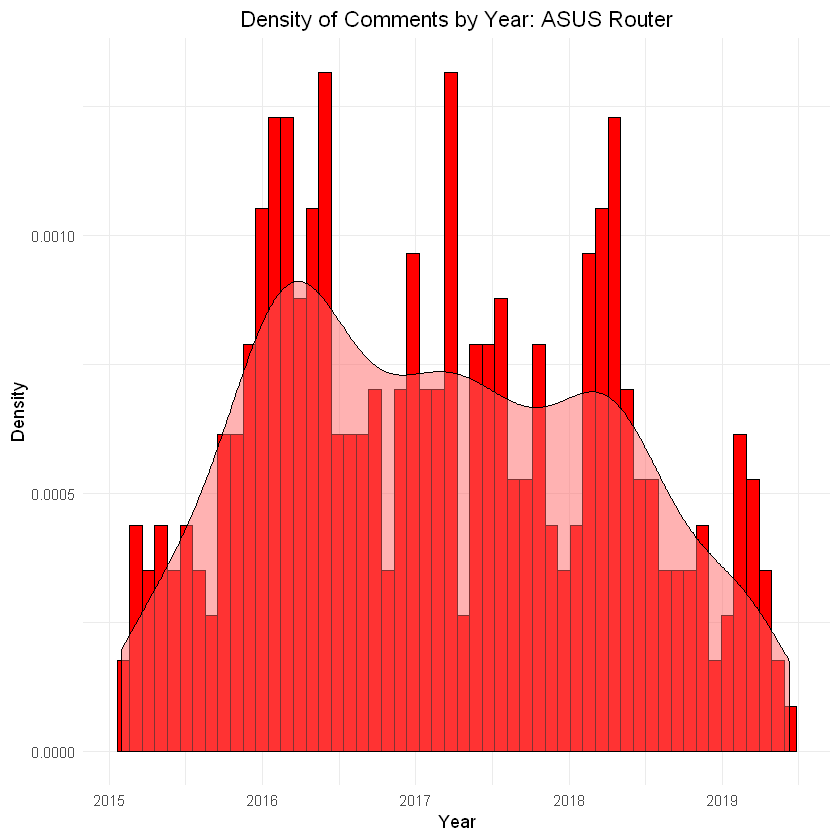

In [9]:
#Create a density plot for date by month

reviews_all$date <- as.Date(reviews_all$date, "%b %d,%Y")
#str(reviews_all$date)

library(scales)
point <- format_format(big.mark = " ", scientific = FALSE)

ggplot(reviews_all, aes(x=date)) + 
  geom_histogram(aes(y=..density..), binwidth = 30, colour="black", fill="red")+
  geom_density(alpha=.5, fill="#FF6666") + 
  ggtitle("Density of Comments by Year: ASUS Router", )  + scale_y_continuous(labels = point) +
  xlab('Year') + ylab('Density') + th

#### ANALYSIS

The Density plot shows a somewhat typical pattern with regards to limited life products such as a router. The router is introduced in 2015 and reviews start to trickle in. Reviews reach a peak the following year and then tapers down as the product gets older.

In [10]:
#Define a function that will clean the text in the comments

clean_reviews <- function(df) {
  
  clean_reviews <- df$comment
  
  #clean formatting
  clean_reviews <- gsub("&amp;", "", clean_reviews)
  clean_reviews <- gsub("^RT", "", clean_reviews)
  clean_reviews <- gsub("/n", "", clean_reviews)
  
  # remove all the punctuation
  clean_reviews <- gsub("[[:punct:]]", "", clean_reviews)
  
  # remove control characters
  clean_reviews <- gsub('[[:cntrl:]]', "", clean_reviews)
  
  # remove html links
  clean_reviews <- gsub("http\\w+", "", clean_reviews)
  
  # remove tabs spaces
  clean_reviews <- gsub("[ |\t]{2,}", "", clean_reviews)
  
  # Encoding(text) <- c("UTF-8")
  # remove all non-ASCII characters
  clean_reviews <- iconv(clean_reviews, "UTF-8", "ASCII", sub = "")
  
  return(clean_reviews)
  
}

In [11]:
#Define function that further cleans text and coverts to Corpus
#Note: we moved obvious words such as ASUS And router from the corpus. 

create_corpus <- function(df) {
  
  clean_reviews <- df$cleantext
  
  #keep only unique items
  clean_reviews = unique(clean_reviews)
  
  review_corpus <- Corpus(VectorSource(clean_reviews))
  
  # Remove contraction
  #review_corpus <- tm_map(review_corpus, content_transformer(replace_contraction))
  
  # Remove abbreviation
  #review_corpus <- tm_map(review_corpus, content_transformer(replace_abbreviation))
  
  # Remove numbers
  review_corpus <- tm_map(review_corpus, removeNumbers)
  
  # Remove punctuation
  review_corpus <- tm_map(review_corpus, removePunctuation)
  
  # All lowercase
  review_corpus <- tm_map(review_corpus, content_transformer(tolower))
  
  # Remove white spaces
  review_corpus <- tm_map(review_corpus, stripWhitespace)
  
  # Remove common words, a.k.a. Stop words
  review_corpus <- tm_map(review_corpus, removeWords, stopwords ("english"))
  
  # Remove custom, common words
  review_corpus <- tm_map(review_corpus, removeWords,
                         c("asus", "router"))
  
  #stem the corpus
  review_corpus <- tm_map(review_corpus, stemDocument)
  
  #lemmatize the corpus
  review_corpus <- tm_map(review_corpus, lemmatize_strings)
  
  return(review_corpus)
  
}


In [12]:
#Call functions to clean text and create the corpus

reviews_all$cleantext <- clean_reviews(reviews_all)
myCorpus <- create_corpus(reviews_all)

In [13]:
#Convert to tdm
myTdm <- TermDocumentMatrix(myCorpus, control = list(minWordLength = 3))
#myTdm <- DocumentTermMatrix(myCorpus, control = list(minWordLength = 3))
inspect(myTdm[1:10,1:10])

<<TermDocumentMatrix (terms: 10, documents: 10)>>
Non-/sparse entries: 23/77
Sparsity           : 77%
Maximal term length: 12
Weighting          : term frequency (tf)
Sample             :
              Docs
Terms          1 10 2 3 4 5 6 7 8 9
  accordinglyi 1  0 0 0 0 0 0 0 0 0
  app          1  2 1 0 0 0 0 0 0 0
  aprx         1  0 0 0 0 0 0 0 0 0
  ask          1  0 0 0 1 1 0 0 0 0
  band         1  2 0 0 2 1 7 0 0 8
  blast        1  0 0 0 0 0 0 0 0 0
  buff         1  0 0 0 0 0 0 0 0 0
  bug          1  0 0 0 0 0 1 0 0 0
  cell         1  0 0 0 0 0 0 0 0 0
  channel      1  0 0 0 0 1 6 1 0 0


#### ANALYSIS
The above code cleans the text by stripping out whitespaces, punctuations, stopwords, etc and stems and lemmatizes the words. The words "ASUS" and 'Router" have also been removed as these are likely to be in most reviews and thus, unhelpful with any analysis. The comments are then conveted to a term document matrix (TDM). A TDM is a matirx describes the frequency of terms that occur in a collection of documents. As shown above, the terms are listed down the side while documents are listed across the top with the respective frequency of occurence.

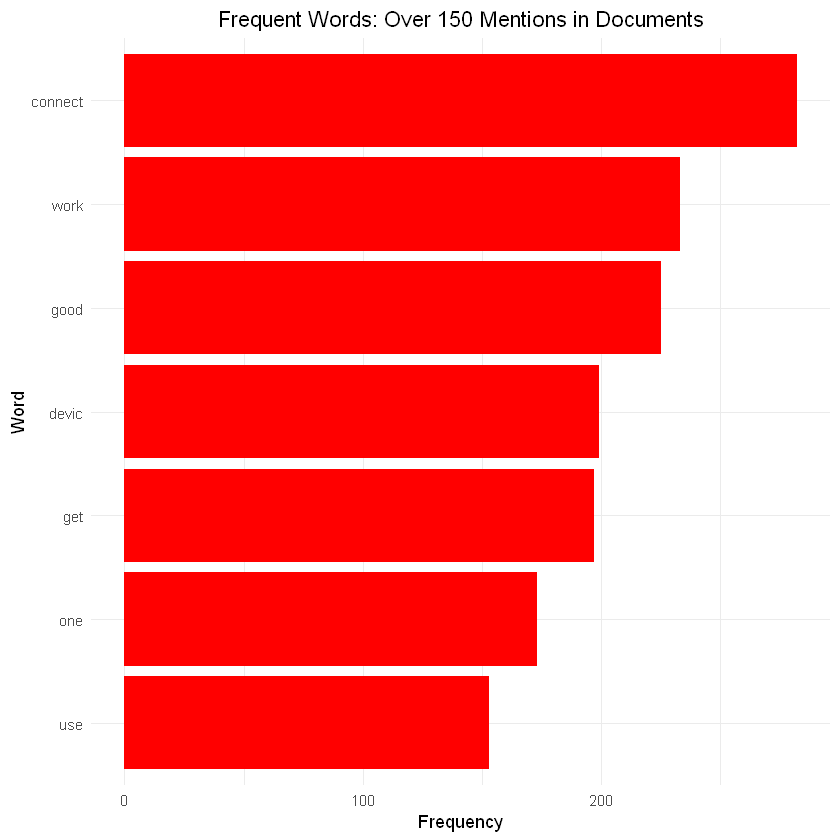

In [14]:
#Graph Freq words
freq <- sort(rowSums(as.matrix(removeSparseTerms(myTdm, .99))), decreasing =TRUE)
wf <- data.frame(word=names(freq), freq=freq)
ggplot(subset(wf,freq>150), aes(reorder(word, freq), freq)) + 
  geom_bar(stat="identity", fill = "red") + ggtitle('Frequent Words: Over 150 Mentions in Documents') +
  theme(axis.text.x=element_text(angle=45,hjust=1)) +
  xlab("Word") + ylab("Frequency") +
  coord_flip() + th

In [15]:
#Find Associations
#library(dplyr)
findAssocs(myTdm, "help", 0.40)

$help
    support      backon   calledhow       flyer     michael networkingi 
       0.48        0.45        0.45        0.45        0.45        0.45 
productwors  questionsi        rest samesimilar      ticket      timein 
       0.45        0.45        0.45        0.45        0.45        0.45 
     timesi     upanoth    utilityi      withat     compani        hand 
       0.45        0.45        0.45        0.45        0.42        0.42 
   overlook 
       0.42

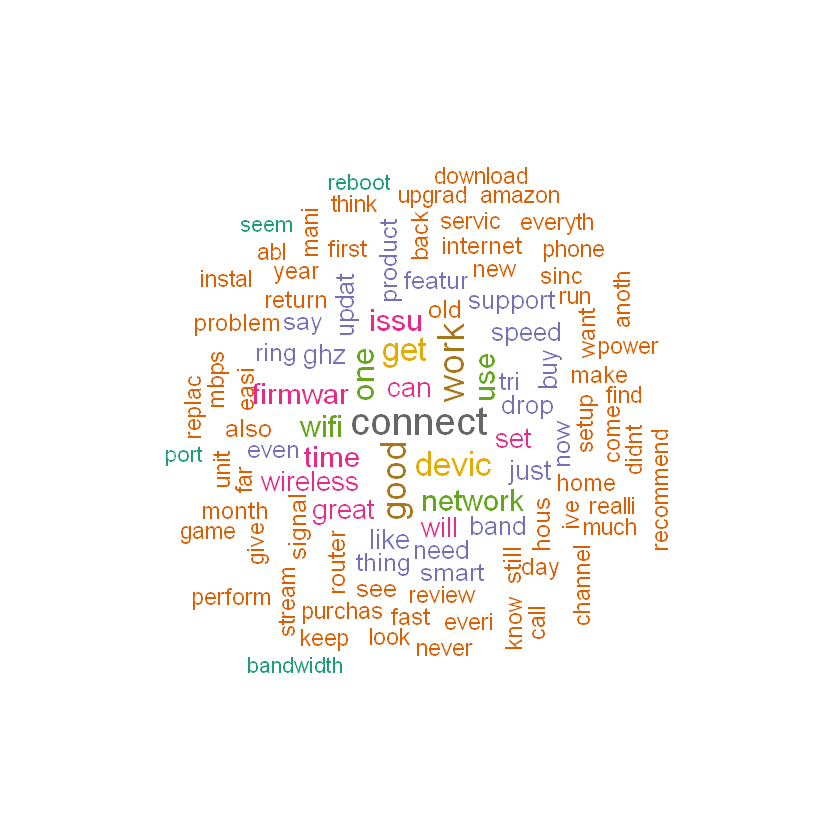

In [16]:
#wordcloud
wordcloud(myCorpus, scale=c(2,1), max.words=100, random.order=FALSE,
          rot.per=0.35, use.r.layout=FALSE,
          colors=brewer.pal(8, "Dark2"))

#### ANALYSIS  
The most common words in the comments, exluding the words ASUS and router are 'connect', 'work', 'device', 'good, 'get', 'one', 'use'. All positive words in context of rating a router and reflective of the generally good reviews the items receives. Looking at associations, if we look at common terms associated with the word 'help', words such as support and ticket are present.  
  
Wordclouds are generally the most overrated graphic in Text Analytics and the example above is no different. Generally, positive words are present, but otherwise, there isn't much to be gleaned from this graphic.


## Topic Modelling

In [17]:
#Find the top 5 topics in the corpus using LDA (Latent Dirichlet Allocation)

smyTdm <- removeSparseTerms(myTdm, 0.90) # This makes a matrix that is only 90% empty space, maximum.   
#inspect(smyTdm)

myTdmT<-t(smyTdm)
rowTotals<- apply(myTdmT, 1, sum)
myTdmT<- myTdmT[rowTotals> 0,]


k = 5 #Note: How many topics you want to extract
SEED = 5234
my_TM = list(VEM = LDA(myTdmT, k = k, control = list(seed = SEED)),
             VEM_fixed = LDA(myTdmT, k = k,
                             control = list(estimate.alpha = FALSE, seed = SEED)),
             Gibbs = LDA(myTdm, k = k, method = "Gibbs",
                         control = list(seed = SEED, burnin = 1000, thin = 100, iter = 1000)),
             CTM = CTM(myTdm, k = k, control = list(seed = SEED, var = list(tol = 10^-4),
                                                    em = list(tol = 10^-3))))
Topic = topics(my_TM[["VEM"]], 1)
table(Topic)
Terms = terms(my_TM[["VEM"]], 10) #Note: Where X = terms per topic
Terms



Topic
 1  2  3  4  5 
47 68 93 95 65 

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
use,one,work,get,connect
connect,time,good,work,devic
firmwar,good,featur,can,network
issu,wireless,great,wifi,get
time,connect,just,hous,good
work,ghz,get,also,set
one,devic,ring,firmwar,band
like,wifi,thing,like,issu
ghz,even,still,ive,updat
buy,can,issu,will,tri


#### ANALYSIS
Running Latent Dirichlet Allocation (LDA) on the corpus extracts topics and associated words. In this case, 5 topics were extracted. Topic 4 is present in 95 comments while topic 1 is present in 47. In general, these 5 most present topics are generally positive to the router.

## Cluster Analysis using Hierachical and K-Means

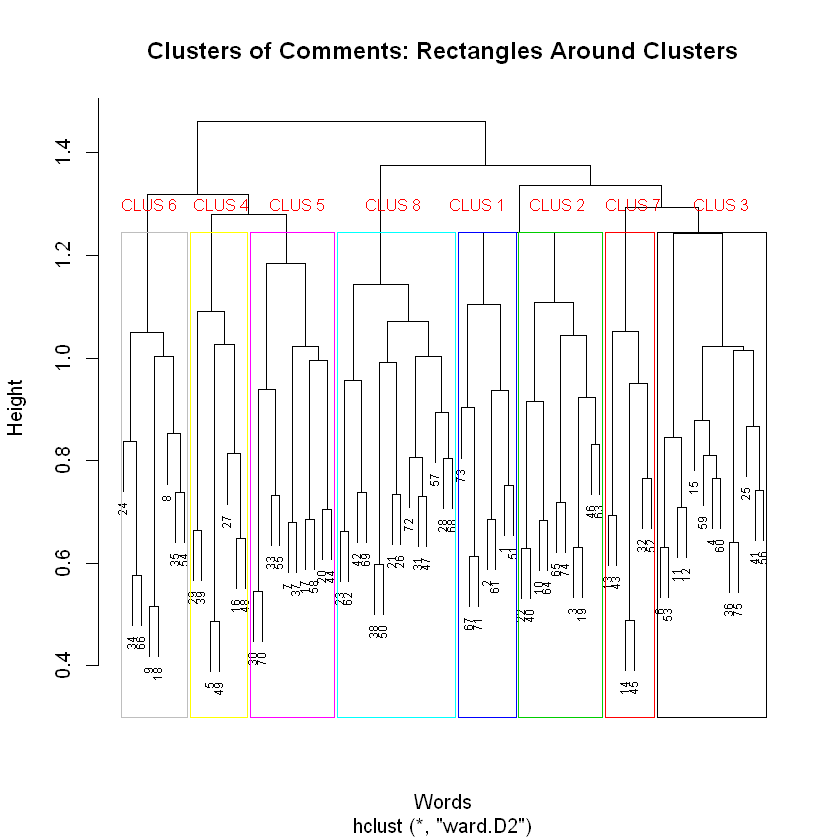

In [18]:


#Traspose the TDM to a DTM then create a cluster using cosine similarity and TD-IDF
Clusmat<- scale(as.matrix(weightTfIdf(t(smyTdm[,1:75]))), center = TRUE, scale = TRUE)

d <- dist(x=Clusmat,method='cosine') #create distance measure
pfit <- hclust(d, method="ward.D2")
plot(pfit, cex = .6, main = "Clusters of Comments: Rectangles Around Clusters", xlab ="Words")
rect.hclust(pfit, k=8, border = 8:1) #Note: Draw rectangle around X clusters
text(37, 1.3, "CLUS 6    CLUS 4     CLUS 5          CLUS 8       CLUS 1      CLUS 2     CLUS 7        CLUS 3",cex = .8, col = 'red')   

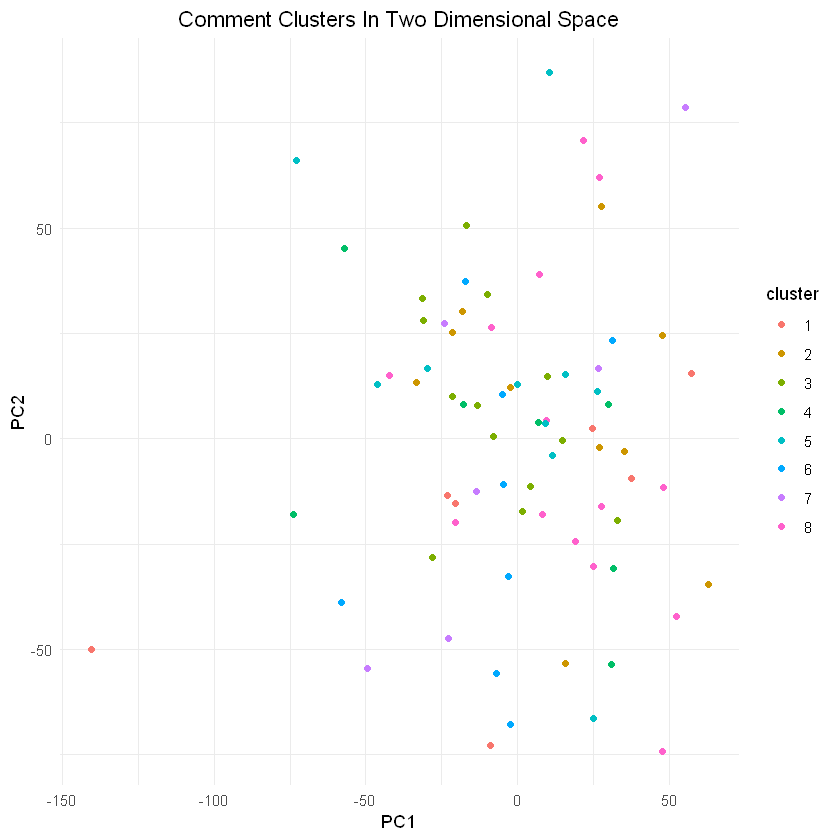

In [19]:
#Project clusters on the two dimensional plane using PCA

groups <- cutree(pfit, k=8) #Note: X = Number of Clusters
princ <- prcomp(Clusmat)
nComp <- 2 
project <- predict(princ, newdata=Clusmat)[,1:nComp]
#Note using PCA , select PC1 and PC2
project.plus <- cbind(as.data.frame(project), cluster=as.factor(groups), identifier=rownames(Clusmat))
#Note using "groups" from the Print Cluster Function, this code creates a dataframe with the PC, Clusters and identifier
ggplot(project.plus, aes(x=PC1, y=PC2)) + geom_point(aes(color=cluster)) + ggtitle('Comment Clusters In Two Dimensional Space') + theme(plot.title = element_text(hjust = 0.5)) + th
 

[1] 4185.667

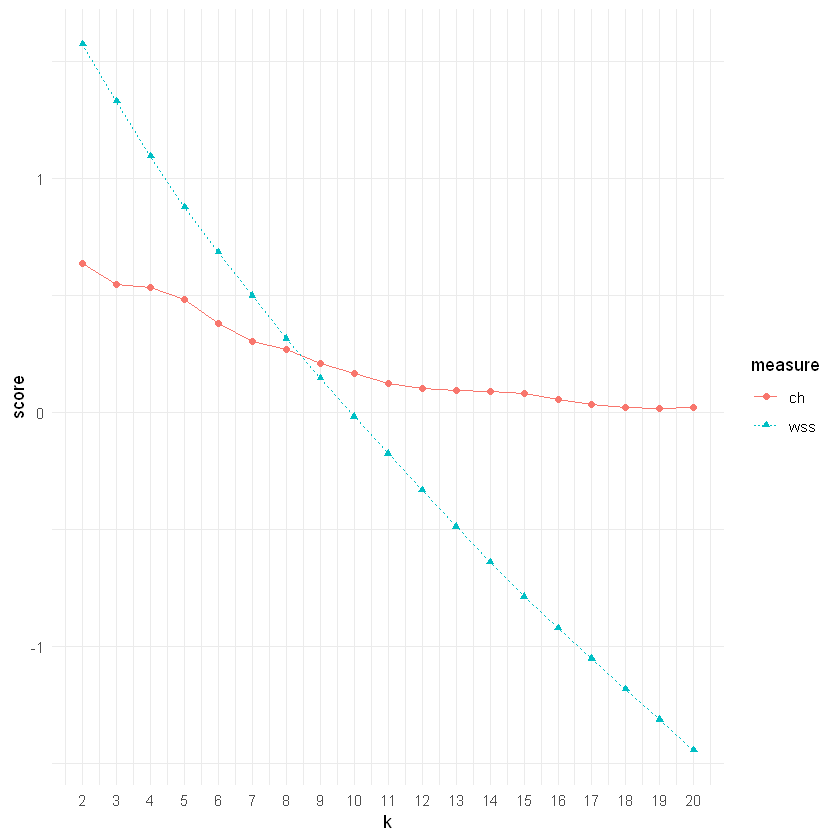

In [20]:
#pick total number of clusters

sqr_edist <- function(x, y) {sum((x-y)^2) }

wss.cluster <- function(clustermat) { 
  c0 <- apply(clustermat, 2, FUN=mean)
  sum(apply(clustermat, 1, FUN=function(row){sqr_edist(row,c0)})) }

wss.total <- function(dmatrix, labels) {
  wsstot <- 0 
  k <- length(unique(labels)) 
  for(i in 1:k)
    wsstot <- wsstot + wss.cluster(subset(dmatrix, labels==i)) 
  wsstot }

wss.total(Clusmat, groups)

totss <- function(dmatrix) {
  grandmean <- apply(dmatrix, 2, FUN=mean)
  sum(apply(dmatrix, 1, FUN=function(row){sqr_edist(row, grandmean)}))
}

ch_criterion <- function(dmatrix, kmax, method="kmeans") {
  if(!(method %in% c("kmeans", "hclust"))) {
    stop("method must be one of c('kmeans', 'hclust')")
  }
  npts <- dim(dmatrix)[1] # number of rows.
  totss <- totss(dmatrix)
  wss <- numeric(kmax)
  crit <- numeric(kmax)
  wss[1] <- (npts-1)*sum(apply(dmatrix, 2, var))
  for(k in 2:kmax) {
    if(method=="kmeans") {
      clustering<-kmeans(dmatrix, k, nstart=10, iter.max=100)
      wss[k] <- clustering$tot.withinss
    }else { # hclust
      d <- dist(dmatrix, method="euclidean")
      pfit <- hclust(d, method="ward.D2")
      labels <- cutree(pfit, k=k)
      wss[k] <- wss.total(dmatrix, labels)
    }
  }
  bss <- totss - wss
  crit.num <- bss/(0:(kmax-1))
  crit.denom <- wss/(npts - 1:kmax)
  crit = crit.num/crit.denom
  list(crit = crit, wss = wss, totss = totss)
}

library(reshape2)
clustcrit <- ch_criterion(Clusmat, 20, method="hclust")
clustcrit[["crit"]][1] = 0
critframe <- data.frame(k=1:20, ch=scale(clustcrit$crit), wss=scale(clustcrit$wss)) #Note call and scale WSS and CH
critframe <- melt(subset(critframe,critframe$k>1), id.vars=c("k"), variable.name="measure", value.name="score")

ggplot(critframe, aes(x=k, y=score, color=measure)) +
  geom_point(aes(shape=measure)) + geom_line(aes(linetype=measure)) +
  scale_x_continuous(breaks=1:20, labels=1:20) + theme_minimal()

#### ANALYSIS  
Clustering comments for this product is a challenge given the overwhelming majority of positve comments with regards to the router. As seen above, there really isn't a clear separation among the clusters. The ability to separate comments using cluster analysis with TF-IDF seems limted in this example. What about clustering words based on the frequency they appear in the documents?

### Cluster Analysis Based on Words

In [21]:
inspect(smyTdm)

<<TermDocumentMatrix (terms: 65, documents: 380)>>
Non-/sparse entries: 3855/20845
Sparsity           : 84%
Maximal term length: 8
Weighting          : term frequency (tf)
Sample             :
         Docs
Terms     117 19 345 374 4  5 6 69  9 94
  connect   6  1   8   2 0 23 5 13 23  0
  devic    12  1   1   4 1 26 4  9 20  3
  get       1  6   0   2 5 11 6  2  1  7
  good      2  1   5   5 5 13 2  3  3  3
  issu      5  5   0   6 0  8 1  2  1  3
  network   4  2   3   1 1 19 1 10  5 11
  one       1  1   0   5 2  1 5  4 13  1
  use      12  7   4   1 1  5 3  4  1  0
  wifi      2  2   0   1 2  2 0  0  0  0
  work      0  4   7   2 4  4 6  2  4  2


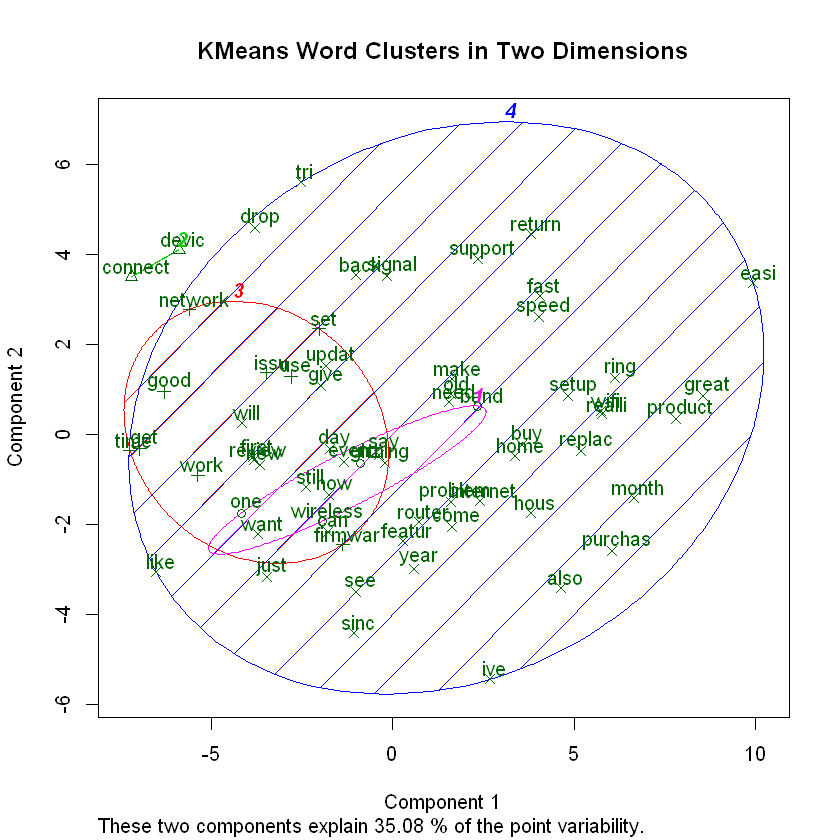

In [22]:
#Try KMEAN cluster on words (not documents). Plot using the more complex clusplot.

Clusmat <- as.matrix(smyTdm)
d <- dist(x=Clusmat,method='cosine') #create distance measure

kbest.p = 4                 
kclusters <- kmeans(Clusmat, kbest.p, nstart=100, iter.max=100)
groups <- kclusters$cluster #Note: slot
clusplot(as.matrix(d), groups, color=TRUE, shade=TRUE, 
         labels=2, lines=0, main = "KMeans Word Clusters in Two Dimensions")  #clusplot is more elaborate

#### ANALYSIS
Similarly to comments, there is considerable overlap among word clusters in two dimensional space (PCA) using Kmeans.

## Sentiment Analysis


Attaching package: 'syuzhet'

The following object is masked from 'package:scales':

    rescale



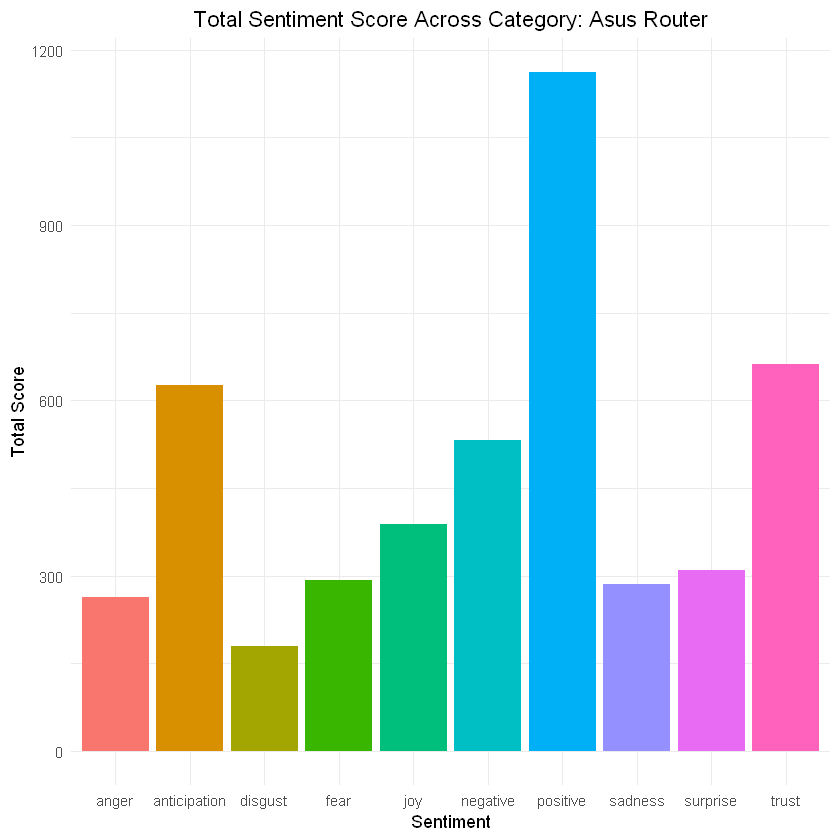

In [23]:
#Sentiment Analysis
suppressWarnings(library(syuzhet))

rm('sentiment')
calculate_sentiment <- function(reviews_all) {
  
  if ("cleantext" %in% colnames(reviews_all)) {
    sentiment <- get_nrc_sentiment(reviews_all$cleantext)}
  else {
    reviews_all$cleantext <- clean_reviews(reviews_all)
    sentiment <- get_nrc_sentiment(reviews_all$cleantext)}
  
  sentiment <- get_nrc_sentiment(reviews_all$cleantext)
  reviews_all <- cbind(reviews_all, sentiment)
  
  sentiment_totals <- data.frame(colSums(reviews_all[,c(5:14)]))

  
  names(sentiment_totals) <- "count"
  sentiment_totals <- cbind("sentiment" = rownames(sentiment_totals), sentiment_totals)
  rownames(sentiment_totals) <- NULL
  
  ggplot(data = sentiment_totals, aes(x = sentiment, y = count)) +
    geom_bar(aes(fill = sentiment), stat = "identity") +
    theme(legend.position = "none") +
    xlab("Sentiment") + ylab("Total Score") + ggtitle("Total Sentiment Score Across Category: Asus Router") + th + theme(legend.position = "none")
}


#rm(myCorpus)
calculate_sentiment(reviews_all)

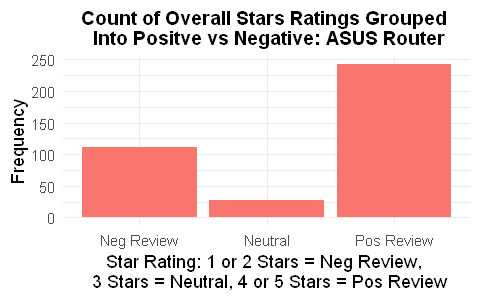

In [24]:
#Bar Chart of Stars
library(repr)
options(repr.plot.height=2.5, repr.plot.width=4)

reviews_all$stars_comb <- ifelse(reviews_all$stars <= 2, 'Neg Review', ifelse((reviews_all$stars >= 4), 'Pos Review', 'Neutral'))


ggplot(reviews_all) + geom_bar(aes(stars_comb, fill="red")) +
 ggtitle('Count of Overall Stars Ratings Grouped \n Into Positve vs Negative: ASUS Router') + th +
 theme(legend.position = "none", plot.title = element_text(color="Black", size=11.5, face="bold"),) +
 xlab('Star Rating: 1 or 2 Stars = Neg Review, \n 3 Stars = Neutral, 4 or 5 Stars = Pos Review') +
 ylab("Frequency")

### ANALYSIS  
Overall, the sentiment across categories is quite positive for the router. Total sentiment score for positive is almost twice is large as negative. Similary, grouping the star ratings into negative, positive and neutral show a similar positive to negative ratio. Overall this router is generally viewed as positve by consumers who rated it on Amazon.